# Importy

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import seaborn as sns
import numpy as np
from numpy import arange
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
import math

# Ładowanie danych

In [2]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/pro1d/'
housing = pd.read_csv(path + 'Housing.csv', header='infer')

Mounted at /content/drive


# Wstępne analizy

In [3]:
#Wymiar danych: Funkcja  DataFrame.shape
print(housing.shape)

#Lista atrybutów z typami: Funkcja:  DataFrame.info
print(housing.info())

#czy wartości brakujące
print(housing.isnull())

#czy w ogóle są jakieś wartości brakujące
print(housing.isnull().values.any())

#sprawdzenie czy są wartości odstające
numeric_housing = housing.select_dtypes(include='number')

for column in numeric_housing.columns:
  Q1 = numeric_housing[column].quantile(0.25)
  Q3 = numeric_housing[column].quantile(0.75)
  IQR = Q3 - Q1
  outliers = numeric_housing[(numeric_housing[column] < (Q1 - 1.5 * IQR)) | (numeric_housing[column] > (Q3 + 1.5 * IQR))]
  if not outliers.empty:
    print(f'W kolumnie {column} są wartości odstające.')

#zakresy wartości danych
range_values = numeric_housing.max() - numeric_housing.min()

for column in range_values.index:
    print(f'Kolumna: {column}, Zakres: {range_values[column]}')

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0          False     False               False        False           False   
1          False     False               False        False           False 

# Wizualizacja

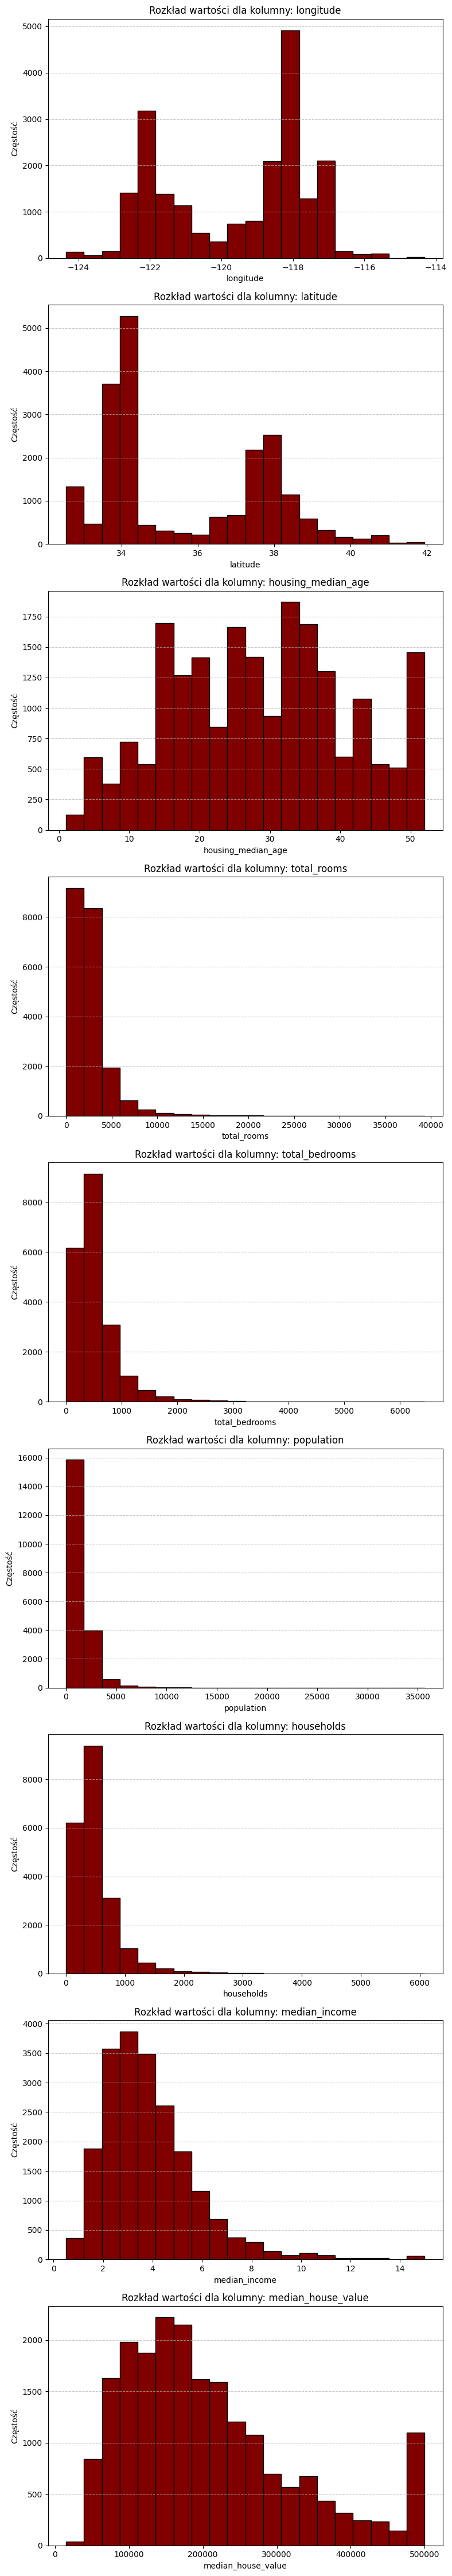

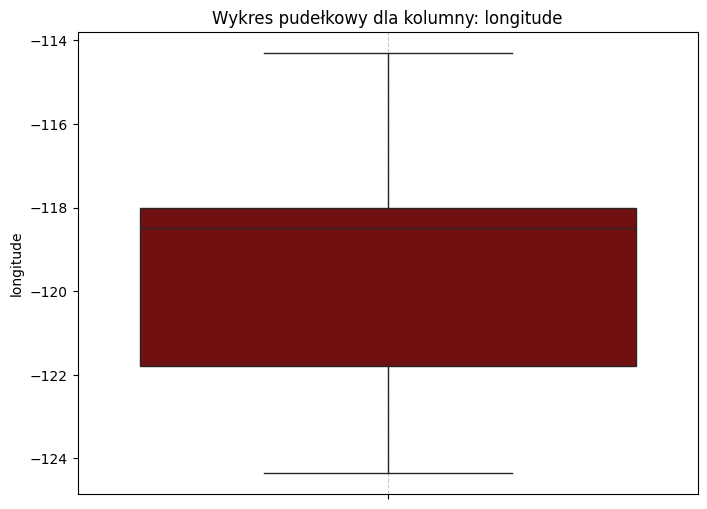

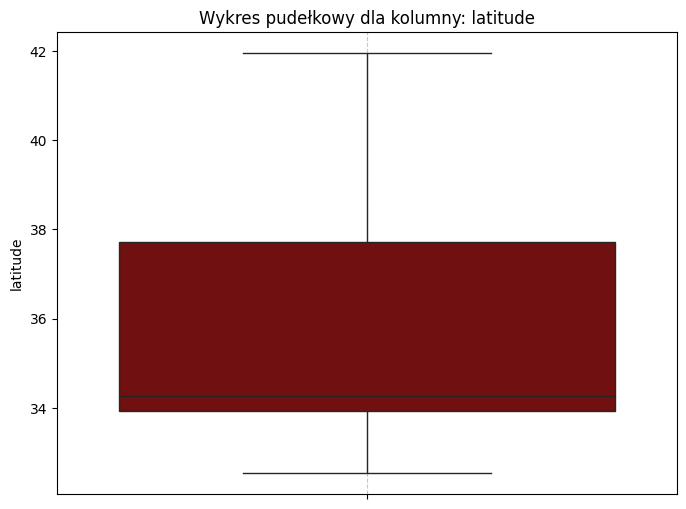

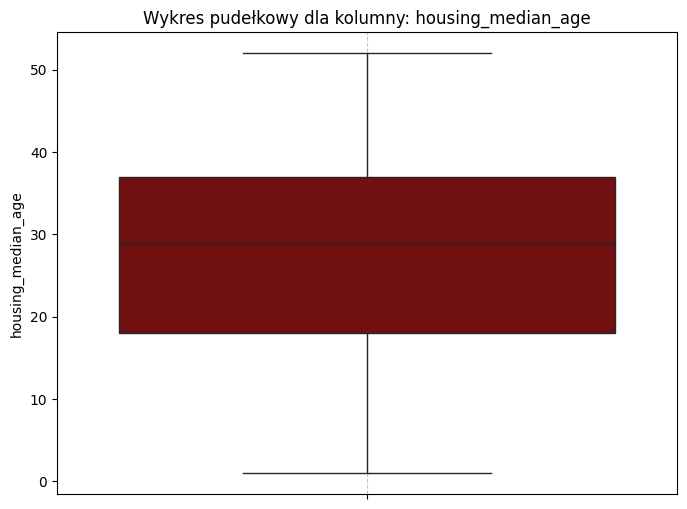

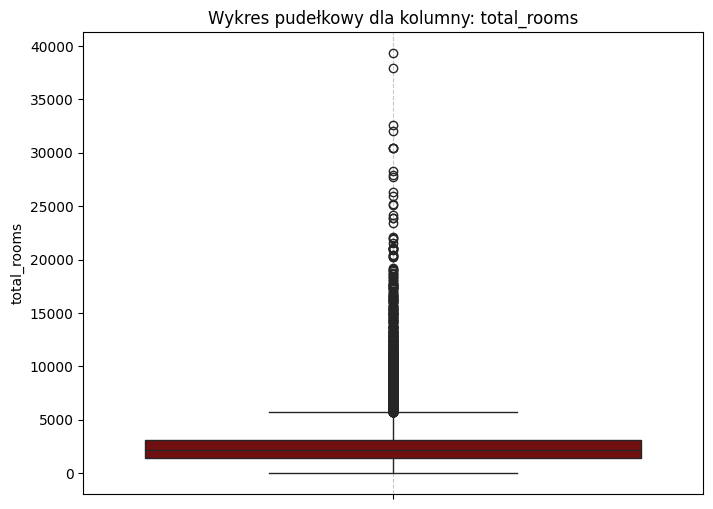

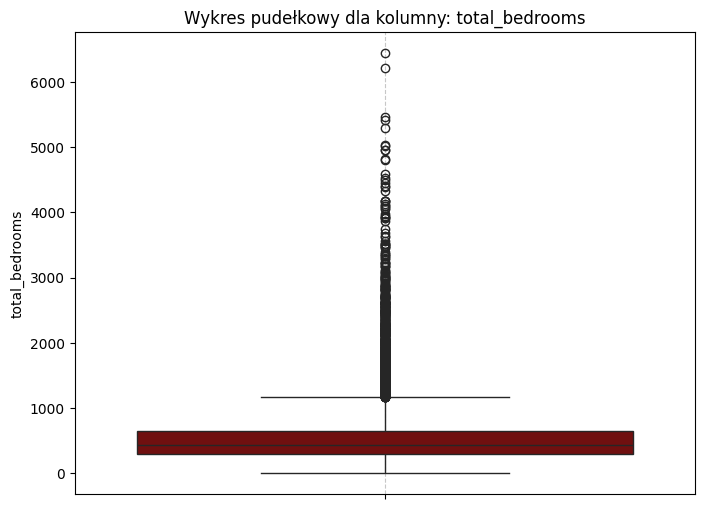

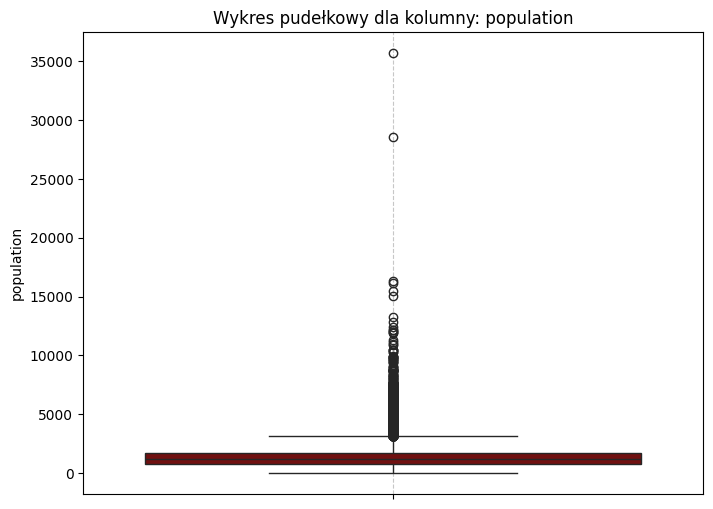

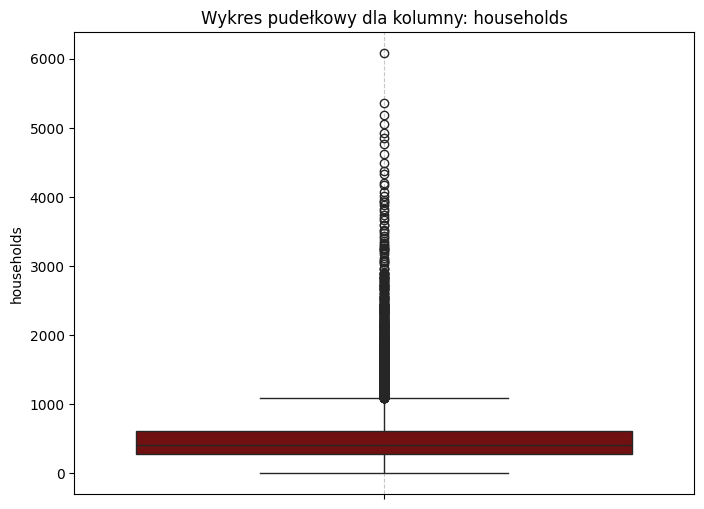

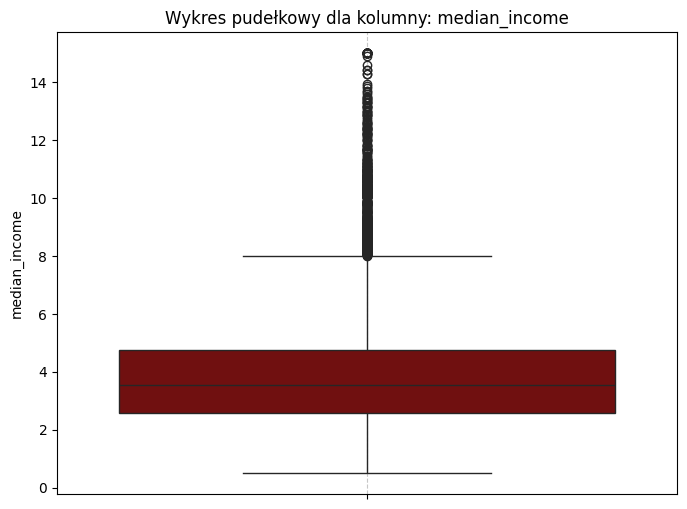

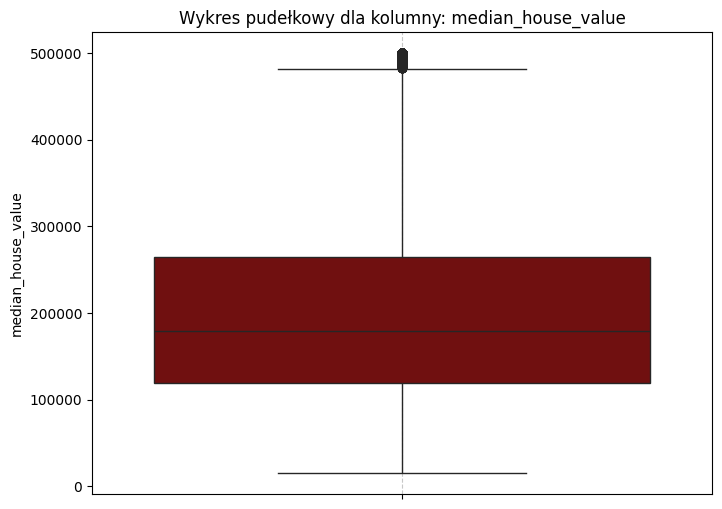

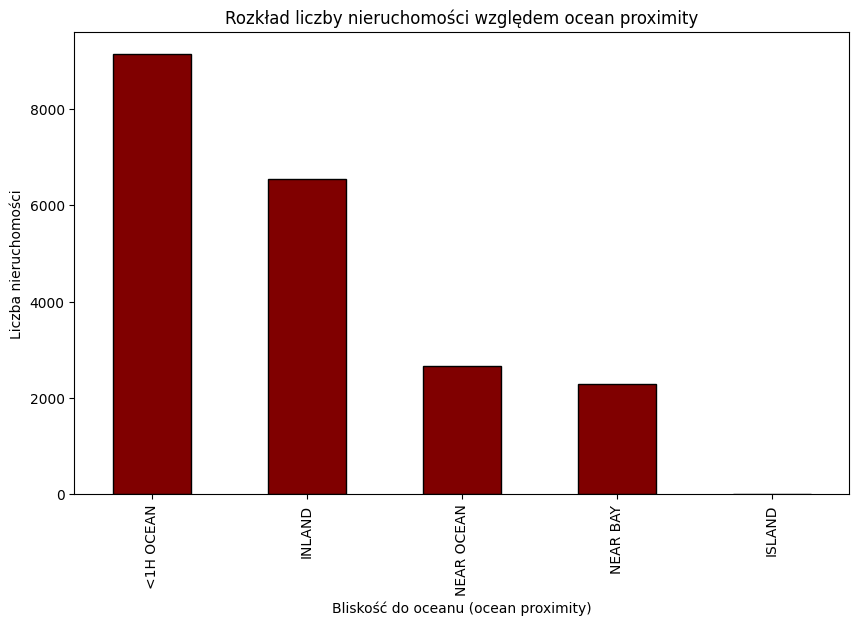

In [4]:
#histogramy
num_cols = len(numeric_housing.columns)

fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(8, 5*num_cols))

for i, column in enumerate(numeric_housing.columns):
    axes[i].hist(numeric_housing[column], bins=20, color='maroon', edgecolor='black')
    axes[i].set_title(f'Rozkład wartości dla kolumny: {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Częstość')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#wykresy pudełkowe
for column in numeric_housing.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=numeric_housing[column], color='maroon')
    plt.title(f'Wykres pudełkowy dla kolumny: {column}')
    plt.ylabel(column)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

#wykres punktowy dla położenia nieruchomości(ocean proximity)
plt.figure(figsize=(10, 6))
housing['ocean_proximity'].value_counts().plot(kind='bar', color='maroon', edgecolor='black')
plt.title('Rozkład liczby nieruchomości względem ocean proximity')
plt.xlabel('Bliskość do oceanu (ocean proximity)')
plt.ylabel('Liczba nieruchomości')
plt.show()

# Analiza korelacji

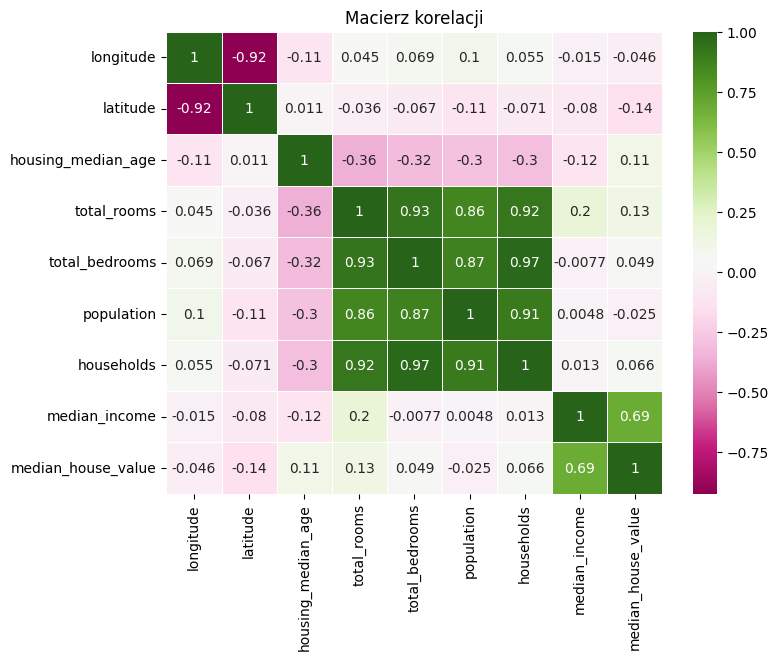

Atrybut najbardziej skorelowany z median_house_value:
median_income

Cechy uporządkowane względem malejącej korelacji z median_house_value:
['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms', 'population', 'longitude', 'latitude']


In [ ]:
#usunięcie zmiennej kategorycznej 'ocean_proximity' i obliczenie macierzy korelacji
housing_nums_only = housing.drop('ocean_proximity', axis=1)
correlation_matrix = housing_nums_only.corr()

#wizualizacja macierzy korelacji
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', linewidths=0.7)
plt.title('Macierz korelacji')
plt.show()


correlations = correlation_matrix['median_house_value']
sorted_correlations = correlations.sort_values(ascending=False)

#wyświetlenie atrybutu najbardziej skorelowanego z 'median_house_value'
print("Atrybut najbardziej skorelowany z median_house_value:")
print(sorted_correlations.index[1])

#uporządkowanie cech względem malejącego współczynnika korelacji z 'median_house_value'
print("\nCechy uporządkowane względem malejącej korelacji z median_house_value:")
print(sorted_correlations.index[1:].tolist())

# Przygotowanie danych

In [ ]:
# konwertowanie brakujacych wartosci na srednia i kodowanie ocean proximity
housing['ocean_proximity'] = housing['ocean_proximity'].astype('category').cat.codes
housing.fillna(housing.mean(), inplace=True)

#usunięcie wartości odstających
housing_no_outliers = housing.copy()
for column in housing_no_outliers.select_dtypes(include='number').columns:
    Q1 = housing_no_outliers[column].quantile(0.25)
    Q3 = housing_no_outliers[column].quantile(0.75)
    IQR = Q3 - Q1
    housing_no_outliers = housing_no_outliers[(housing_no_outliers[column] >= (Q1 - 1.5 * IQR)) &
                                              (housing_no_outliers[column] <= (Q3 + 1.5 * IQR))]

#normalizacja danych
numeric_columns = housing_no_outliers.select_dtypes(include='number').columns
scaler = StandardScaler()

housing_no_outliers[numeric_columns] = scaler.fit_transform(housing_no_outliers[numeric_columns])

print(housing_no_outliers)

#podział na zbiór uczący i testowy
x = housing_no_outliers.drop("median_house_value", axis=1)
y = housing_no_outliers["median_house_value"].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)





       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
701    -1.489609  0.974328            0.312972    -0.762717       -1.157999   
830    -1.500741  0.960122           -1.649929     1.543615        1.443169   
859    -1.489609  0.941182           -0.625806     2.197866        1.805421   
860    -1.484042  0.945917           -1.137867     1.455542        0.869604   
862    -1.500741  0.945917            0.227629     0.780967        0.270882   
...          ...       ...                 ...          ...             ...   
20635  -0.999779  1.845569           -0.284432    -0.393007       -0.252370   
20636  -1.066574  1.850304           -0.881837    -1.329864       -1.379375   
20637  -1.072140  1.821894           -0.967180     0.177043        0.306101   
20638  -1.127803  1.821894           -0.881837    -0.204281       -0.076275   
20639  -1.083273  1.793484           -1.052524     0.690959        0.965198   

       population  households  median_income  media

# Modelowanie

RMSE dla regresji liniowej: 0.6084659265722066


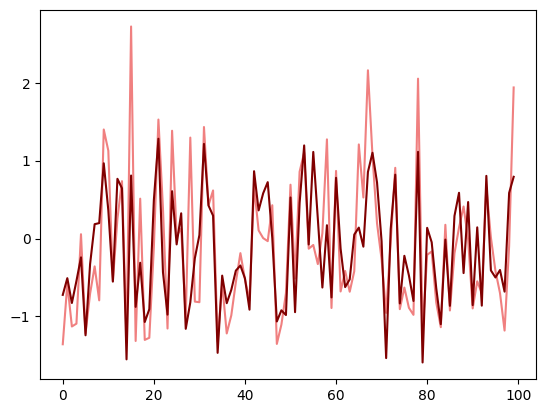

In [ ]:
#regresja liniowa
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

housing_predictions = lin_reg.predict(x_test)

lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f'RMSE dla regresji liniowej: {lin_rmse}')

#wizualizacja
x = np.arange(0, 100, 1)
y = y_test[:100]
z = housing_predictions[:100]

plt.plot(x, y, color='lightcoral', label='true value')
plt.plot(x, z, color='maroon', label='pred value')


RMSE dla regresji liniowej z regulacją L1: 0.6769336836703298


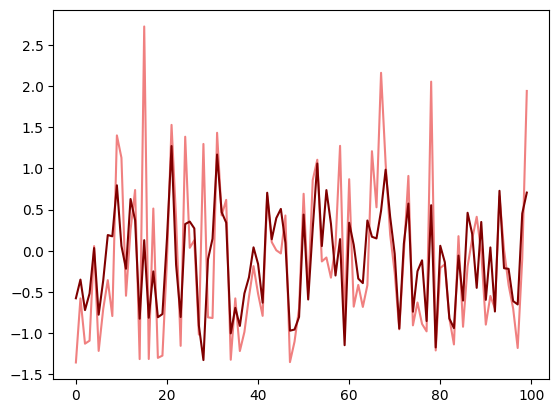

In [ ]:
#regresja liniowa z regulacją L1(Lasso)
model = Lasso(alpha=0.1)
model.fit(x_train, y_train)

housing_predictions = model.predict(x_test)

lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f'RMSE dla regresji liniowej z regulacją L1: {lin_rmse}')

#wizualizacja
x = np.arange(0, 100, 1)
y = y_test[:100]
z = housing_predictions[:100]

plt.plot(x, y, color='lightcoral', label='true value')
plt.plot(x, z, color='maroon', label='pred value')

RMSE dla regresji liniowej z regulacją L2: 0.6084764322105289


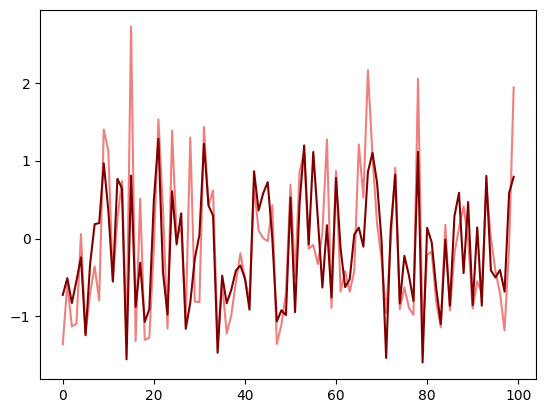

In [ ]:
#regresja liniowa z regulacją L2(Ridge)
model = Ridge(alpha=1.0)
model.fit(x_train, y_train)

housing_predictions = model.predict(x_test)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f'RMSE dla regresji liniowej z regulacją L2: {lin_rmse}')

#wizualizacja
x = np.arange(0, 100, 1)
y = y_test[:100]
z = housing_predictions[:100]

plt.plot(x, y, color='lightcoral', label='true value')
plt.plot(x, z, color='maroon', label='pred value')

In [ ]:
#regresja liniowa z regulacją L2(Ridge) i strojeniem parametrów
model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha']=arange(0, 1, 0.01)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


MAE: -0.436
Config: {'alpha': 0.99}


RMSE dla regresyjnego drzewa decyzyjnego: 0.5855489022598518


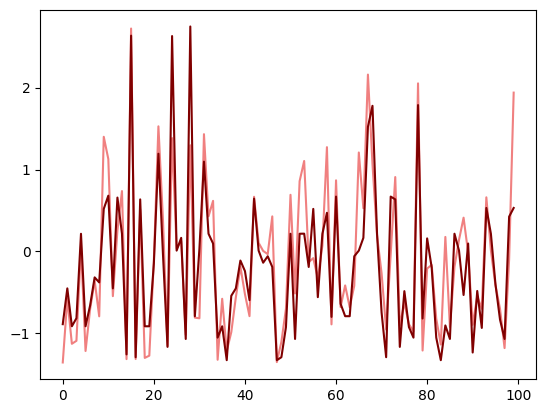

In [ ]:
#regresyjne DT
model = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=10)
model.fit(x_train, y_train)

housing_predictions = model.predict(x_test)

lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f'RMSE dla regresyjnego drzewa decyzyjnego: {lin_rmse}')

#wizualizacja
x = np.arange(0, 100, 1)
y = y_test[:100]
z = housing_predictions[:100]

plt.plot(x, y, color='lightcoral', label='true value')
plt.plot(x, z, color='maroon', label='pred value')

In [ ]:
#regresyjne DT ze strojniem parametrów
model = DecisionTreeRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['max_depth']=arange(1, 20, 2)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(x_train, y_train)

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.375
Config: {'max_depth': 9}


RMSE dla regresyjnego RandomForest: 0.4744978587830864


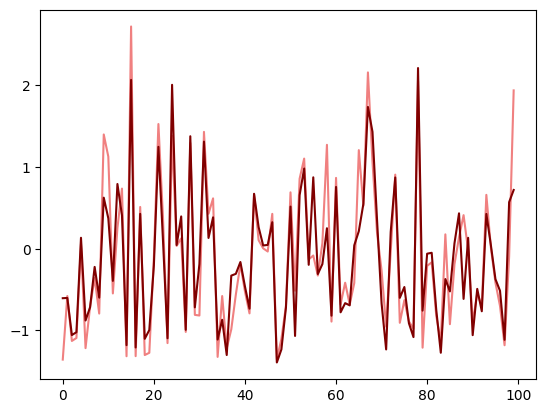

In [ ]:
#regresyjne RandomForest
model = RandomForestRegressor(n_estimators=100, criterion='squared_error')
model.fit(x_train, y_train)

housing_predictions = model.predict(x_test)

lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f'RMSE dla regresyjnego RandomForest: {lin_rmse}')

#wizualizacja
x = np.arange(0, 100, 1)
y = y_test[:100]
z = housing_predictions[:100]

plt.plot(x, y, color='lightcoral', label='true value')
plt.plot(x, z, color='maroon', label='pred value')